In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

root_dir = "/content/drive/MyDrive/"
import os
os.chdir(root_dir + 'Projects8/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model


In [ ]:
images_path = '/content/drive/MyDrive/Projects8/stanford_images/'
images = glob(images_path+'*.jpg')
print("Total images in dataset:",len(images))
for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
incept_model = ResNet50(include_top=True)
last = incept_model.layers[-2].output
CNNmodel = Model(inputs = incept_model.input,outputs = last)

In [ ]:
#dont run
images_features = {}
count = 0
print("Converting images to features using CNN model")
for i in images:
   img = cv2.imread(i)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   img = cv2.resize(img, (224,224))
   img = img.reshape(1,224,224,3)
   pred = CNNmodel.predict(img).reshape(2048,)
   img_name = i.split('/')[-1]
   images_features[img_name] = pred
   count += 1
   if count % 500 == 0:
       print("Completed for "+str(count)+" images")
print("length of image features:",len(images_features))
list(images_features.items())[:5]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 204ms/step
Completed for 15000 images
1/1 [==============================] - 0s 328ms/step
Completed for 15500 images
1/1 [==============================] - 0s 190ms/step
Completed for 16000 images
1/1 [==============================] - 0s 189ms/step
Completed for 16500 images
1/1 [==============================] - 0s 199ms/step
Completed for 17000 images
1/1 [==============================] - 0s 324ms/step
Completed for 17500 images
1/1 [==============================] - 0s 321ms/step
Completed for 18000 images
1/1 [==============================] - 0s 210ms/step
Completed for 18500 images
1/1 [==============================] - 0s 189ms/step
Completed for 19000 images
1/1 [==============================] - 0s 204ms/step
Completed for 19500 images
1/1 [==============================] - 0s 322ms/step
length of image features: 19551


[('2413143.jpg',
  array([0.5753334 , 1.3754464 , 0.7780704 , ..., 1.6563107 , 0.67958367,
         1.3660941 ], dtype=float32)),
 ('2412921.jpg',
  array([0.53582835, 2.2092967 , 0.00519723, ..., 0.22178996, 0.3876614 ,
         0.34260964], dtype=float32)),
 ('2413514.jpg',
  array([0.7086986 , 1.2648218 , 0.01207004, ..., 1.8179698 , 0.05910106,
         0.05403604], dtype=float32)),
 ('2413260.jpg',
  array([0.35020882, 0.02035255, 0.7241618 , ..., 1.3520516 , 0.69863945,
         0.3810844 ], dtype=float32)),
 ('2412853.jpg',
  array([0.4811237 , 0.40189168, 0.00915444, ..., 0.71496904, 0.8840933 ,
         1.5178931 ], dtype=float32))]

In [ ]:
#dont run
import pickle

with open("/content/drive/MyDrive/Projects8/picklefiles/a.pkl","wb") as f:
    pickle.dump(images_features , f)
#with open("/content/drive/MyDrive/Projects8/picklefiles/a.pkl","rb") as f:
 #   images_features=pickle.load(f)


In [ ]:
import pickle
with open("/content/drive/MyDrive/Projects8/picklefiles/a.pkl","rb") as f:
    images_features=pickle.load(f)
print(images_features)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
num_images=len(images_features)
print(num_images)

19551


In [ ]:
caption_path = '/content/drive/MyDrive/Projects8/stanford_df_rectified.csv'

with open(caption_path) as csvfile:
    captions=csv.reader(csvfile, delimiter=',', quotechar='"')
    captions_dict_train,captions_dict_test,captions_dict_val= {},{},{}
    for i in captions:
        try:
            img_name = i[0]  + ".jpg"
            caption = i[1]
            train_input=i[2]
            test_input=i[3]
            val_input=i[5]
            if img_name in images_features:
                if train_input=='True':
                    captions_dict_train[img_name] = caption
                elif test_input=='True':
                    captions_dict_test[img_name] = caption
                elif val_input=='True':
                    captions_dict_val[img_name] = caption
        except:
            pass

print("size of train, test and validation dataset:" ,len(captions_dict_train),len(captions_dict_test),len(captions_dict_val))

size of train, test and validation dataset: 14575 2489 2487


In [ ]:
def preprocessed(txt):
    modified = txt.lower().replace('.',' .').replace("'","")
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

count_words = {}
print("Captions before preprocessing\n ",list(captions_dict_train.items())[:5])

for k,v in captions_dict_train.items():
    captions_dict_train[k]=preprocessed(v)

#creating count_words dict with word and frequency
for k,v in captions_dict_train.items():
    for word in v.split():
        if word not in count_words:
            count_words[word] = 1
        else:
            count_words[word] += 1

#creating words_dict as vocabulary where only words occuring more than threshold is considered
THRESH = 5
count = 1
words_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        words_dict[k] = count
        count += 1

#captions_dict converting words into numbers from words_dict
for k, v in captions_dict_train.items():
    encoded = []
    for word in v.split():
        if word in words_dict.keys():
            encoded.append(words_dict[word])

    captions_dict_train[k] = encoded

print("Captions after preprocessing\n ",list(captions_dict_train.items())[:5])

Captions before preprocessing
  [('2317429.jpg', 'A white round plate is on a table with a plastic tablecloth on it.  Two foil covered food halves are on the white plate along with a serving of golden yellow french fries.  Next to the white plate in a short,  topless, plastic container is a white sauce.  Diagonal to the white plate are the edges of several other stacked plates.  There are black shadows reflected on the table.'), ('2365091.jpg', 'A large red and white train is traveling on tracks in a what looks to be a rural area. There are trees and hills in the background and the ground looks dry. The train has many large windows for the passengers to look out of. The train is mostly white with red on the front upper part of the train and red stripes and trim on the sides. The roof of the train is grey.'), ('2383120.jpg', 'A very clean and tidy a bathroom. Everything is a neat porcelain white. This bathroom is both retro and modern.'), ('2333990.jpg', 'There are four small pizzas on 

In [ ]:
#import pickle

with open("/content/drive/MyDrive/Projects8/picklefiles/words_dict.pkl", "wb") as f:
   pickle.dump(words_dict , f)
print(words_dict)

{'startofseq': 1, 'a': 2, 'white': 3, 'round': 4, 'plate': 5, 'is': 6, 'on': 7, 'table': 8, 'with': 9, 'plastic': 10, 'tablecloth': 11, 'it': 12, '.': 13, 'two': 14, 'foil': 15, 'covered': 16, 'food': 17, 'halves': 18, 'are': 19, 'the': 20, 'along': 21, 'serving': 22, 'of': 23, 'golden': 24, 'yellow': 25, 'french': 26, 'fries': 27, 'next': 28, 'to': 29, 'in': 30, 'short,': 31, 'container': 32, 'sauce': 33, 'diagonal': 34, 'edges': 35, 'several': 36, 'other': 37, 'stacked': 38, 'plates': 39, 'there': 40, 'black': 41, 'shadows': 42, 'reflected': 43, 'endofseq': 44, 'large': 45, 'red': 46, 'and': 47, 'train': 48, 'traveling': 49, 'tracks': 50, 'what': 51, 'looks': 52, 'be': 53, 'rural': 54, 'area': 55, 'trees': 56, 'hills': 57, 'background': 58, 'ground': 59, 'dry': 60, 'has': 61, 'many': 62, 'windows': 63, 'for': 64, 'passengers': 65, 'look': 66, 'out': 67, 'mostly': 68, 'front': 69, 'upper': 70, 'part': 71, 'stripes': 72, 'trim': 73, 'sides': 74, 'roof': 75, 'grey': 76, 'very': 77, 'cle

In [ ]:
import pickle
with open("/content/drive/MyDrive/Projects8/picklefiles/words_dict.pkl","rb") as f:
    words_dict=pickle.load(f)
print(words_dict)

{'startofseq': 1, 'a': 2, 'white': 3, 'round': 4, 'plate': 5, 'is': 6, 'on': 7, 'table': 8, 'with': 9, 'plastic': 10, 'tablecloth': 11, 'it': 12, '.': 13, 'two': 14, 'foil': 15, 'covered': 16, 'food': 17, 'halves': 18, 'are': 19, 'the': 20, 'along': 21, 'serving': 22, 'of': 23, 'golden': 24, 'yellow': 25, 'french': 26, 'fries': 27, 'next': 28, 'to': 29, 'in': 30, 'short,': 31, 'container': 32, 'sauce': 33, 'diagonal': 34, 'edges': 35, 'several': 36, 'other': 37, 'stacked': 38, 'plates': 39, 'there': 40, 'black': 41, 'shadows': 42, 'reflected': 43, 'endofseq': 44, 'large': 45, 'red': 46, 'and': 47, 'train': 48, 'traveling': 49, 'tracks': 50, 'what': 51, 'looks': 52, 'be': 53, 'rural': 54, 'area': 55, 'trees': 56, 'hills': 57, 'background': 58, 'ground': 59, 'dry': 60, 'has': 61, 'many': 62, 'windows': 63, 'for': 64, 'passengers': 65, 'look': 66, 'out': 67, 'mostly': 68, 'front': 69, 'upper': 70, 'part': 71, 'stripes': 72, 'trim': 73, 'sides': 74, 'roof': 75, 'grey': 76, 'very': 77, 'cle

the commented part

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 271)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 271, 271)             1063946   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_1[0][0]']             
                                                                                              

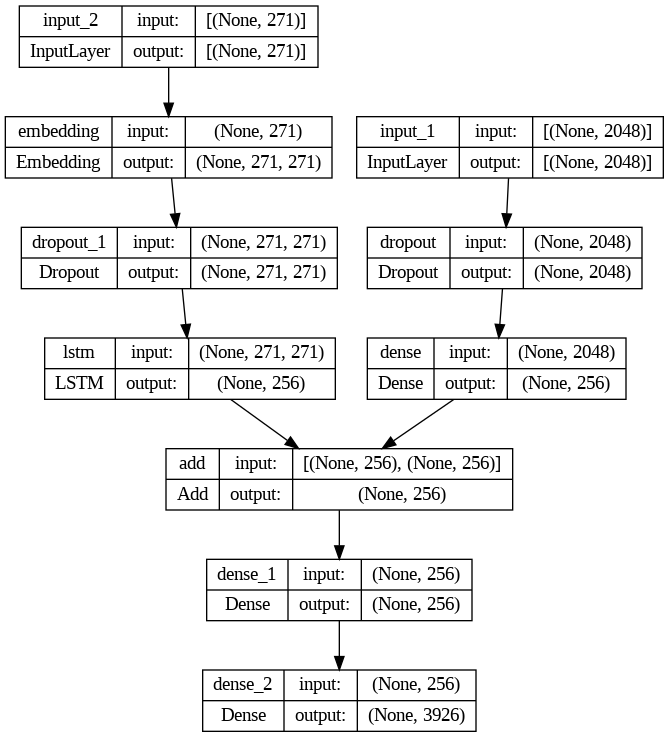

In [ ]:

vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# language sequence model
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(vocab_size, MAX_LEN, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# summarize model
model.summary()
plot_model(model, show_shapes=True)


In [ ]:
N=32 #BatchSize
VOCAB_SIZE = len(words_dict)+1

def progressive_generator(photo_dict, caption_dict, MAX_LEN,VOCAB_SIZE):
    while 1:
        for i in range(0,len(caption_dict),N):
            caption = dict(list(caption_dict.items())[0+i: N+i])
            X, y_in, y_out = create_sequences(photo_dict,caption,MAX_LEN, VOCAB_SIZE)
            yield [X, y_in], y_out


def create_sequences(photo, caption, MAX_LEN,VOCAB_SIZE):
    #n_samples = 0
    X,y_in,y_out = [],[],[]

    for k, v in caption.items():
        for i in range(1, len(v)):
            X.append(photo[k])

            in_seq= [v[:i]]
            out_seq = v[i]

            in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

            y_in.append(in_seq)
            y_out.append(out_seq)

    return np.array(X), np.array(y_in), np.array(y_out)

In [ ]:
steps = len(captions_dict_train)/N
generator = progressive_generator(images_features, captions_dict_train, MAX_LEN, VOCAB_SIZE)
model.fit(generator, epochs=50, steps_per_epoch=steps, verbose=1)
model.save('/content/drive/MyDrive/Projects8/imagecaptioningmodels/image_caption_model_newarch50_original' + '.h5')

Epoch 1/50
455/455 [==============================] - 98s 216ms/step - loss: 2.7498 - accuracy: 0.4191
Epoch 2/50
455/455 [==============================] - 96s 210ms/step - loss: 2.6646 - accuracy: 0.4274
Epoch 3/50
455/455 [==============================] - 95s 209ms/step - loss: 2.5968 - accuracy: 0.4344
Epoch 4/50
455/455 [==============================] - 95s 208ms/step - loss: 2.5396 - accuracy: 0.4399
Epoch 5/50
455/455 [==============================] - 95s 209ms/step - loss: 2.4902 - accuracy: 0.4453
Epoch 6/50
455/455 [==============================] - 95s 209ms/step - loss: 2.4460 - accuracy: 0.4499
Epoch 7/50
455/455 [==============================] - 95s 209ms/step - loss: 2.4063 - accuracy: 0.4544
Epoch 8/50
455/455 [==============================] - 96s 210ms/step - loss: 2.3715 - accuracy: 0.4583
Epoch 9/50
455/455 [==============================] - 95s 209ms/step - loss: 2.3395 - accuracy: 0.4621
Epoch 10/50
455/455 [==============================] - 95s 209ms/step - l

In [ ]:
from IPython.display import FileLink
FileLink(r'/content/drive/MyDrive/Projects8/picklefiles/words_dict.pkl')

/content/drive/MyDrive/Projects8/picklefiles/words_dict.pkl

In [ ]:
steps = len(captions_dict_train)/N
generator = progressive_generator(images_features, captions_dict_train, MAX_LEN, VOCAB_SIZE)
model.fit(generator, epochs=250, steps_per_epoch=steps, verbose=1)
model.save('/content/drive/MyDrive/Projects8/imagecaptioningmodels/image_caption_model_newarch250' + '.h5')

Epoch 1/250
455/455 [==============================] - 130s 267ms/step - loss: 3.8648 - accuracy: 0.3027
Epoch 2/250
455/455 [==============================] - 100s 219ms/step - loss: 3.0712 - accuracy: 0.3870
Epoch 3/250
455/455 [==============================] - 100s 220ms/step - loss: 2.8698 - accuracy: 0.4075
Epoch 4/250
455/455 [==============================] - 100s 220ms/step - loss: 2.7517 - accuracy: 0.4192
Epoch 5/250
455/455 [==============================] - 100s 220ms/step - loss: 2.6664 - accuracy: 0.4275
Epoch 6/250
455/455 [==============================] - 99s 217ms/step - loss: 2.5994 - accuracy: 0.4341
Epoch 7/250
455/455 [==============================] - 100s 219ms/step - loss: 2.5430 - accuracy: 0.4396
Epoch 8/250
455/455 [==============================] - 99s 218ms/step - loss: 2.4947 - accuracy: 0.4441
Epoch 9/250
455/455 [==============================] - 99s 218ms/step - loss: 2.4510 - accuracy: 0.4489
Epoch 10/250
455/455 [==============================] - 10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

inv_dict = {v:k for k, v in words_dict.items()}
print(inv_dict)

{1: 'startofseq', 2: 'a', 3: 'white', 4: 'round', 5: 'plate', 6: 'is', 7: 'on', 8: 'table', 9: 'with', 10: 'plastic', 11: 'tablecloth', 12: 'it', 13: '.', 14: 'two', 15: 'foil', 16: 'covered', 17: 'food', 18: 'halves', 19: 'are', 20: 'the', 21: 'along', 22: 'serving', 23: 'of', 24: 'golden', 25: 'yellow', 26: 'french', 27: 'fries', 28: 'next', 29: 'to', 30: 'in', 31: 'short,', 32: 'container', 33: 'sauce', 34: 'diagonal', 35: 'edges', 36: 'several', 37: 'other', 38: 'stacked', 39: 'plates', 40: 'there', 41: 'black', 42: 'shadows', 43: 'reflected', 44: 'endofseq', 45: 'large', 46: 'red', 47: 'and', 48: 'train', 49: 'traveling', 50: 'tracks', 51: 'what', 52: 'looks', 53: 'be', 54: 'rural', 55: 'area', 56: 'trees', 57: 'hills', 58: 'background', 59: 'ground', 60: 'dry', 61: 'has', 62: 'many', 63: 'windows', 64: 'for', 65: 'passengers', 66: 'look', 67: 'out', 68: 'mostly', 69: 'front', 70: 'upper', 71: 'part', 72: 'stripes', 73: 'trim', 74: 'sides', 75: 'roof', 76: 'grey', 77: 'very', 78: 

1/1 [==============================] - 0s 20ms/step
BLEU-1: 0.025974
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


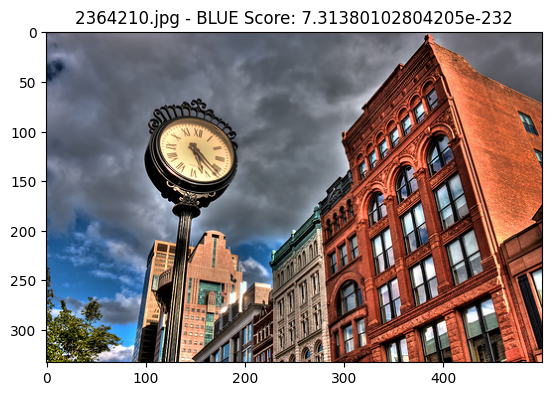

 a clock tower is seen in nature park. the tower has a clock on it. the clock face is white with a black face. the clock face is white with a black face. the clock face is white with a black face. the clock face is white with a black face. the clock face is white with a black face. the clock face is white with a black face. 


In [ ]:
## For selected test images

#2373586.jpg 75 epoch
#2361833.jpg 75 epoch

#2394335.jpg 150 epoch
#2364210.jpg 150 epoch
#2402430.jpg 2395361.jpg 150 epoch
#2335374.jpg 2373374.jpg 150 epoch


model = tf.keras.models.load_model('/content/drive/MyDrive/Projects8/imagecaptioningmodels/image_caption_model_newarch50_original.h5')
img_name='2364210.jpg'
test_feature = images_features[img_name]
test_img_path = '/content/drive/MyDrive/Projects8/stanford_images/'+img_name
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
actual= captions_dict_test[img_name].split()

blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

plt.figure()
plt.imshow(test_img)
plt.title(img_name+" - BLUE Score: "+str(blueScore))
plt.show()
print(caption.replace(' .','.'))

1/1 [==============================] - 0s 20ms/step


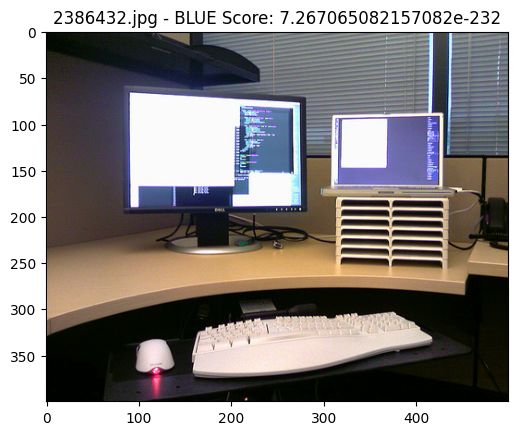

 a computer monitor is on a desk. the monitor is white with a black circle. the screen is on a cream colored desk. there is a white tag on the desk. the laptop is open. the desk is brown. the desk has a black keyboard and mouse pad and keyboard. the monitor is on a wooden desk. the desk is brown. a small desk hutch is on the right. 
BLEU-1: 0.025316
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
1/1 [==============================] - 0s 20ms/step


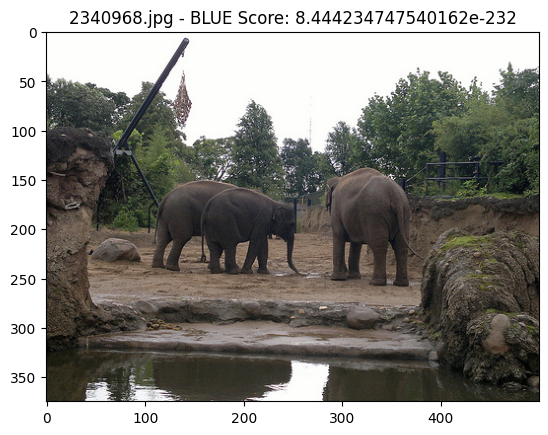

 a large elephant is walking on a dirt ground. the elephant has a long trunk. the trunk is grey and grey, and has a harness on the top. the trunk is white with a little point of water. the elephants trunk is curled up, and floppy. the perimeter of the elephant is curled up, and coated with white accents. 
BLEU-1: 0.046154
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
1/1 [==============================] - 0s 20ms/step


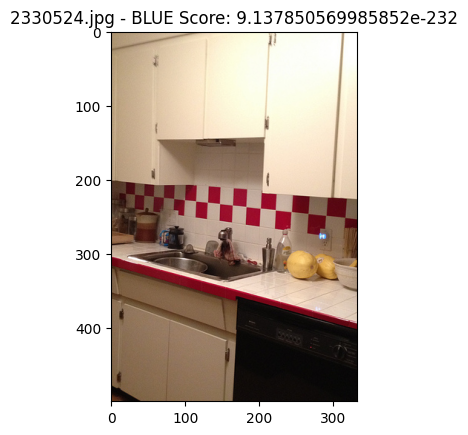

 a man is standing in front of a t.v. holding a white game controller in his ear. a white t.v. is sitting on a t.v. he is wearing a black shirt and blue jean pants. a large white t.v. is sitting on a stand near the mattress. a large brown table is standing near the mattress. a large white tub is in front of the chair. 
BLEU-1: 0.063291
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


In [ ]:
## For random test images

model = tf.keras.models.load_model('/content/drive/MyDrive/Projects8/imagecaptioningmodels/image_caption_model_newarch250.h5')

plt.figure()
for i in range(3):

    num=  np.random.randint(0,len(captions_dict_test))
    img_name=list(captions_dict_test)[num]
    test_feature = images_features[img_name]
    test_img_path = '/content/drive/MyDrive/Projects8/stanford_images/'+img_name

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < MAX_LEN:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(words_dict[i])

        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
        prediction = np.argmax(model.predict(data_list))
        sampled_word = inv_dict[prediction]
        caption = caption + ' ' + sampled_word

        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)

    caption= caption.replace('endofseq','')
    predicted= caption.split()
    actual= captions_dict_test[img_name].split()

    blueScore= sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    plt.imshow(test_img)
    plt.title(img_name+" - BLUE Score: "+str(blueScore))
    plt.show()
    print(caption.replace(' .','.') )
    print('BLEU-1: %f' % sentence_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % sentence_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % sentence_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % sentence_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

